# 1. Learning Objectives

The objective of this lab assignment is that you should get hands-on experience with implementing and using a support vector machine from scratch. In particular, you should be able to:

* Use the mathematical formulation of the optimization task,
* Formulate the indicator function and explain how it relates to the outcome of the classification,
* Predict and explain the outcome of using different kernels,
* Explain the effect of the C-value when using slack variables.

In addition, you will gain some experience in using Python together with the packages numpy, scipy, and matplotlib, commonly used for scientific computing.

# 2. Theory

The idea is to build a classifier which first makes an transformation of the input data, and then a linear separation where the decision boundary is placed to give maximal margins to the available data points. The location of the decision boundary is given by the weights ($\vec{w}$) and the bias (b) so the problem is to find the values for ($\vec{w}$) and b which maximize the margin, i.e. the distance to any datapoint.

## 2.1. Dual Formulation

Given a constrained optimization problem, known as the primal problem, it is possible to express a different but closely related problem, called its dual problem, as shown in equation 5-3 of the book.

Find the values $\alpha^{(i)}$ which minimize:
\begin{align}
\frac{1}{2} \sum_{i=1}^m  \sum_{j=1}^m \alpha^{(i)}  \alpha^{(j)} t^{(i)} t^{(j)} {x^{(i)}}^T x^{(j)} -  \sum_{i=1}^m \alpha^{(i)}
\end{align}

subject to the constraints $\alpha^{(i)} \geqslant 0$ for $ i = 1,2,...,m$  and  $\sum_{i}   \alpha^{(i)} t^{(i)} = 0$

where we have the following notation:

* $\vec{w}$ is the weight vector defining the separating hyperplane
* $b$ is the offset (bias) for the hyperplane
* ${x}_i$ is the $i^{th}$ data point
* $t_i$ is the target class (-1 or 1) for datapoint i

Once you find the vector $\hat{\alpha}$ that minimizes this equation (using a QP solver), you can compute $\hat{w}$ and $\hat{b}$ that minimize the primal problem by using the primal solution shown in equation 5-4 of the book.

\begin{align}
\hat{w} = \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} x^{(i)}
\end{align}
\begin{align}
\hat{b} = \frac{1}{n_{s}} \sum_{i=1}^m (t^{(i)} - {\hat{w}}^T x^{(i)})
\end{align}

## 2.2. Adding Slack Variables

Instead of requiring that every datapoint is outside the margin we will allow for mistakes, quantified by variables $ \zeta ^{i}$ (positive values; one for each datapoint). These are called slack variables. The constraints will now be

\begin{align}
\text{minimize}_{w,b,\zeta} \frac{1}{2} {w}^T w + C \sum_{i=1}^m  \zeta ^{i}
\end{align}
subject to 
\begin{align}
t^{(i)}(w^T x^{(i)} + b) \geqslant 1 - \zeta ^{i} \\ \text{  and  } \zeta ^{i} \geqslant 0 \text{  for i = 1,2,...,m}
\end{align}

## 2.3. Kernel Functions

In Machine Learning, a kernel is a function capable of computing the dot product based only on the original vectors a and b, without having to know about the transformation. The function $K(\vec{x}_i , \vec{x}_j)$ is called a kernel function and computes the scalar value corresponding to $\phi{(x_i)}· \phi{(x_j)}$. This is, however, normally done implicitly, i.e., without actually computing the two vectors and taking their scalar product

Below are some of the most commonly used kernels.

Linear: $ K(a,b) = {a}^T b$

Polynomial: $ K(a,b) = {({a}^T b + r)}^d $

Gaussian RBF: $ K(a,b) = exp(-\gamma {|| a - b ||}^2) $

With the addition of the kernel function, we can rewrite the dual formulation equation from section 2.1 as:

Find the values $\alpha^{(i)}$ which minimize:
\begin{align}
\frac{1}{2} \sum_{i=1}^m  \sum_{j=1}^m \alpha^{(i)}  \alpha^{(j)} t^{(i)} t^{(j)} K(\vec{x}_i , \vec{x}_j) -  \sum_{i=1}^m \alpha^{(i)}
\end{align}


# 3. Implementation

We will use the general purpose optimization function minimize available in the scipy.optimize library as our QP solver. This will work well for the small problems we are dealing with here. For more complex problems, perhaps with thousands of samples, it is better to use one of the special purpose optimizers like LIBSVM developed to be efficient specifically for SVM.

Start by importing minimize from scipy.optimize, along with the other packages you will need:


In [1]:
import numpy as np
import random, math
from scipy.optimize import minimize ## This is your QP solver
import matplotlib.pyplot as plt

The heart of your program will be a single call to the minimize function. A call to minimize should look like this pseudocode:
```
min_ = minimize(objective, alpha_0, bounds = B, constraints = XC)
alpha = min_.x
```
This will find the vector $\vec{\alpha}$ which minimizes the function objective within the bounds B and the constraints XC.

```objective``` is a function you have to define, which takes a vector $\vec{\alpha}$ as argument and returns a scalar value, effectively implementing the expression that should be minimized, in our case the dual formulation equation shown in section 2.1.

```alpha_0``` is a vector with the initial guess of the $\vec{\alpha}$ vector. We can, e.g., simply use a vector of zeros: numpy.zeros(N). N is here the number of training samples (note that each training sample will have a corresponding ${\alpha}$-value).

B is a list of pairs of the same length as the $\vec{\alpha}$ -vector, stating the lower and upper bounds for the corresponding element in $\vec{\alpha}$. To constrain the ${\alpha}$ values to be in the range 0 ≤ ${\alpha}$ ≤ C, we can set ```bounds=[(0, C) for b in range(N)]```. To only have a lower bound, set the upper bound to ```None``` like this: ```bounds=[(0, None) for b in range(N)].```


## 3.1 Generate test data

To test your support vector machine, you will also need code for generating test data and for visualizing the results. In the following sections you will be given code fragments that you can use directly in your program to achieve this. __You will later need to move the clusters around and change their spread by changing the values in this code sample.__

Hint: If you insert a call ```“numpy.random.seed(100)”``` before the code that generates the data, you will get the same random data every time you run the program. This can help during debugging.

In [2]:
# Create dataset
classA = np.random.randn(100, 2) * 0.3 + [1.5,0.5]
classB = np.random.randn(200, 2) * 0.3 + [0.0, 0.0]

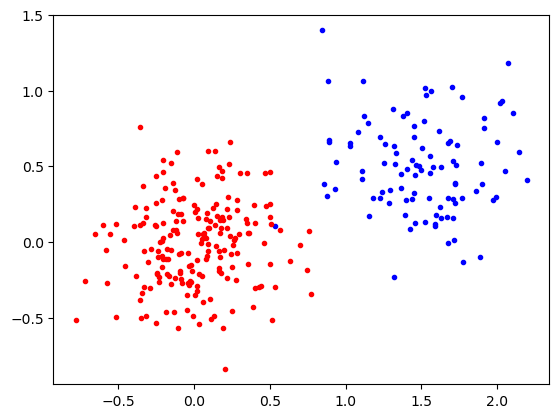

In [3]:
# Let us see how our dataset looks
plt.plot( [ p[0] for p in classA], [ p[1] for p in classA], 'b. ' )
plt.plot( [ p[0] for p in classB], [ p[1] for p in classB], 'r. ' )

xgrid = np.linspace(-5, 5)
ygrid = np.linspace(-3, 3)

plt.axis('equal')           # Force same scale on both axes
plt .show()                 # Show the plot on the screen

In [4]:
# Create vectors with inputs and targets
inputs = np.concatenate((classA , classB))  # x and y coordinates for the data
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))  # holds the +1 or -1 values for the inputs, their indices in the list coincide respectively

n_train = inputs.shape[0]  # Number of samples

#The last four lines randomly reorder the samples. 
permute = list(range(n_train))
random.shuffle(permute)
inputs = inputs[permute, : ]  # Training values
targets = targets[permute]    # Training labels

## 3.2. For you to implement

You will have to write code for:

### 3.2.1 A suitable kernel function:
  
The kernel function takes two data points as arguments and returns a “scalar product-like” similarity measure; a scalar value. Start with the linear kernel which is the same as an ordinary scalar product, but also explore the other kernels in section 2.3. Create a function for each kernel


In [5]:
# Hint: Let gamma and r in the polynomial be 1

degree = 2 #hyperparameter for polynomial kernel
gamma = 1 #hyperparameter for rbf kernel

def linearKernel(x, y):
    # return ## TO DO ##
    return np.dot(x, y)

def polyKernel(x, y, degree, r=1):
    # return ## TO DO ##
    return (np.dot(x, y) + r) ** degree

def rbfKernel(x, y, gamma):
    # return ## TO DO ##
    return np.exp(-gamma * np.linalg.norm(x - y)**2)

# Set which kernel you want to use
kernel = linearKernel

### 3.2.2 Implement the function objective

Define a function which implements the dual formulation equation shown in section 2.1. This function will only receive the vector $\vec{\alpha}$ as a parameter. You can use global variables for other things that the function needs (t and K values).

Python hint: This function will be called hundreds of times, so it makes sense to care about efficiency.

You can pre-compute a matrix with these values:
\begin{align}
P_{i,j} = t_{i}t_{j}K(x_i,x_j)
\end{align}

In [6]:
# Function to calculate P matrix

def __compute_P_mat(t, x, kernel):
        P = np.zeros((len(x), len(x)))
        for i in range(len(x)):
            for j in range(len(x)):
                # P[i][j] = ## TO DO ##
                P[i][j] = t[i] * t[j] * kernel(x[i], x[j])
        return P

Indices i and j run over all the data points. Thus, if you have N data points, P should be an N × N matrix. This matrix should be computed only once, outside of the function objective. Therefore, store it as a numpy array in a global variable.
Inside the ```objective``` function, you can now make use of the functions ```numpy.dot``` (for vector-vector, vector-matrix, and matrix-vector multiplications), and numpy.sum (for summing the elements of a vector). This is much faster than explicit for-loops in Python.


In [7]:
# Objective function which we want to minimize

def __objective(alpha):
        # return ## TO DO ##
        return 0.5 * np.dot(alpha, np.dot(P, alpha)) - np.sum(alpha)

### 3.2.3 Implement the function zerofun
This function should implement the equality constraint in section 2.1. Also here, you can make use of numpy.dot to be efficient.


In [8]:
# def __zerofun(alpha):
#         return np.dot(np.transpose(alpha), targets)

def __zerofun(alpha, targets):
    return np.dot(alpha, targets)

### 3.2.4 Call minimize
Make the call to minimize as indicated in the code sample given in the introduction of section 3. Note that minimize returns a dictionary data structure; this is why we must must use the string 'x' as an index to pick out the actual ${\alpha}$ values. There are other useful indices that you can use; in particular, the index 'success' holds a boolean value which is True if the optimizer actually found a solution.


In [10]:
## Set your slack variable C
C = 100

## Compute the P matrix
P = __compute_P_mat(targets, inputs, kernel = linearKernel)
alpha_0 = np.zeros(n_train)
bounds = [(0, C) for b in range(n_train)]

# 'targets' as an additional argument to __zerofun via the 'args' tuple
constraint = {'type':'eq', 'fun':__zerofun, 'args': (targets,)}

print("Calling minimize...") # Optional: add print statement for debugging
__min = minimize(__objective, alpha_0, bounds = bounds, constraints = constraint)
print("Minimize call finished.") # Optional: add print statement

# use the string 'x' as an index to pick out the actual alpha values
alpha = __min.x

if __min.success:
    print("Success: Optimization converged.")
else:
    print(f"ERROR: Optimization didn't converge. Reason: {__min.message}")

Calling minimize...
Minimize call finished.
Success: Optimization converged.


### 3.2.5 Extract the non-zero α values

If the data is well separated, only a few of the α values will be non-zero. Since we are dealing with floating point values, however, those that are supposed to be zero will in reality only be approximately zero. Therefore, use a low threshold (10−5 should work fine) to determine which are to be regarded as non-zero.

You need to save the non-zero αi’s along with the corresponding data points (xi) and target values (ti) in a separate data structure, for instance a list.

In [14]:
epsilon = 1e-5

non_zero_vals = []
for i in range(len(alpha)):
    if alpha[i] > epsilon:
        non_zero_vals.append((alpha[i], inputs[i], targets[i]))
        
non_zero_vals

[(27.86282808223091, array([ 0.70113596, -0.02124402]), -1.0),
 (90.25830927062042, array([0.88032326, 0.3046918 ]), 1.0),
 (100.0, array([0.75664011, 0.07448489]), -1.0),
 (100.0, array([0.53465387, 0.10913387]), 1.0),
 (62.39548118847743, array([0.50213962, 0.46373025]), -1.0)]

### 3.2.6 Calculate the b value
Note that you must use a point on the margin. This corresponds to a
point with an α-value larger than zero, but less than C (if slack is used). To compute the b value we need to use equation 5-12 from the book:
\begin{align}
\hat{b} = \frac{1}{n_s} \sum_{i=1}^m \left( t^{i} - \sum_{j=1}^m \hat{\alpha}^{(j)} t^{(j)} K(x^{(i)},x^{(j)}) \right)
\end{align}

In [19]:
def __compute_b():
    support_vector = non_zero_vals[0][1]
    t_support = non_zero_vals[0][2]
    
    for alpha, x, t in non_zero_vals:
        if alpha < C:
            t_support = t
            support_vector = x

    if t_support == 0:
        print("ERROR: Couldn't find alpha < C")
        return 0

    b_result = 0
    for alpha, x, t in non_zero_vals:
        b_result += alpha*t*kernel(support_vector, x)
    return b_result - t_support

b = __compute_b()
print(b)

5.42558590731328


### 3.2.7 Implement the indicator function
Implement the indicator function which uses the non-zero $\alpha_{i}$’s together with their xi’s and ti’s to classify new points. This corresponds to equation 5-11 from the book:

\begin{align}
h_{\hat{w},\hat{b}}(\phi (x^{(n)})) = \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} K(x^{(i)},x^{(n)}) - \hat{b}
\end{align}
where 
$\hat{\alpha}^{(i)} > 0$
 


In [30]:
def indicator(point):

    ## TO DO ##
    total = 0
    to_return = total - b
    for alpha, xi, ti in non_zero_vals:
        total += alpha * ti * kernel(xi, point)
        
    return total - b

SyntaxError: 'return' outside function (4067314164.py, line 9)

# 4. Plotting

In order to see your data, you can use the plot functions from matplotlib. This code will plot your two classes using blue and red dots.

## 4.1. Plotting the decision boundary

In [42]:
def plot(classA, classB):
    # Plot the raw data points
    plt.figure(figsize=(8, 6)) # Adjust figure size if needed
    plt.plot( [ p[0] for p in classA], [ p[1] for p in classA], 'b.', label='Class A' )
    plt.plot( [ p[0] for p in classB], [ p[1] for p in classB], 'r.', label='Class B' )

    # Determine plot bounds based on input data range + margin
    if 'inputs' in globals() and isinstance(inputs, np.ndarray) and inputs.shape[1] == 2:
         x_min, x_max = inputs[:, 0].min() - 1, inputs[:, 0].max() + 1
         y_min, y_max = inputs[:, 1].min() - 1, inputs[:, 1].max() + 1
    else:
         # default range iff 'inputs' not available/valid
         print("debug: input not valid.")
         x_min, x_max = -5, 5
         y_min, y_max = -3, 3

    # Create a grid of points to evaluate the indicator function
    xgrid = np.linspace(x_min, x_max, 60) # Increased points for smoother contour
    ygrid = np.linspace(y_min, y_max, 60)

    # list comprehension; convert to numpy array w/ specific dtype
    grid_values = [[indicator(np.array((x,y))) for x in xgrid] for y in ygrid]
    grid_raw = np.array(grid_values, dtype=float) # Specify dtype=float

    # CORRECTION FOR isfinite ERROR
    grid = np.nan_to_num(grid_raw)

    plt.title(f'SVM Decision Boundary')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()

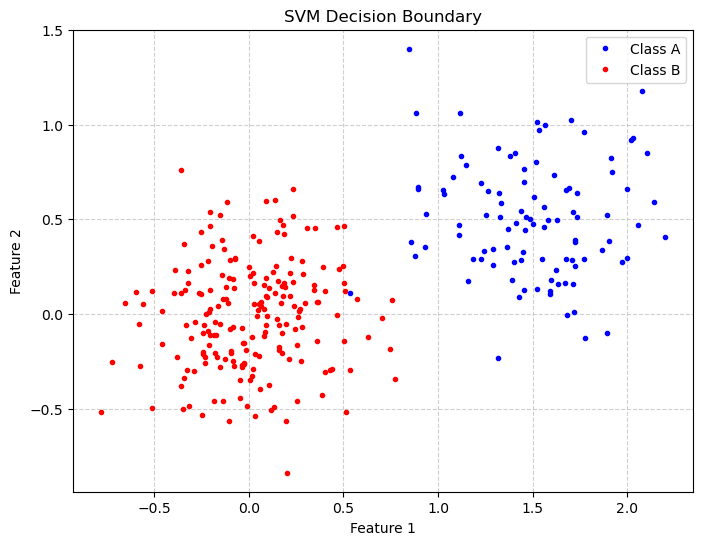

In [43]:
plot(classA, classB)

# 5. Exploring and Reporting

## 5.1 Exploring with linear kernel
(1) Move the clusters in the given dataset around and change their sizes to make it easier or harder for the linear classifier to find a good boundary (for example by overlapping the dataset). Illustrate your answer using labelled plots.

(2) Describe whether the optimizer fails to converge in some cases and why. Illustrate your answer using labelled plots.

In [80]:
import numpy as np ##
import random
import matplotlib.pyplot as plt ##
from scipy.optimize import minimize

P = None
b = 0
non_zero_vals = []
kernel = linearKernel

# Part 5.1.

print("\n5.1(1) Ex. A: Easy Separation WITH Well-Separated Data")

# Parameters
easy_classA_params = {'n': 50, 'std': 0.3, 'center': [2.0, 1.0]}
easy_classB_params = {'n': 50, 'std': 0.3, 'center': [-2.0, -1.0]}
C_value_easy = 1.0

# 1. Generate Data
np.random.seed(101)
classA_easy = np.random.randn(easy_classA_params['n'], 2) * easy_classA_params['std'] + easy_classA_params['center']
classB_easy = np.random.randn(easy_classB_params['n'], 2) * easy_classB_params['std'] + easy_classB_params['center']
inputs_easy = np.concatenate((classA_easy, classB_easy))
targets_easy = np.concatenate((np.ones(classA_easy.shape[0]), -np.ones(classB_easy.shape[0])))
n_train_easy = inputs_easy.shape[0]
permute_easy = list(range(n_train_easy))
random.shuffle(permute_easy)
inputs_easy = inputs_easy[permute_easy, :]
targets_easy = targets_easy[permute_easy]

# 2. Run SVM
P = __compute_P_mat(targets_easy, inputs_easy, kernel) # Set global P
alpha_0_easy = np.zeros(n_train_easy)
bounds_easy = [(0, C_value_easy) for _ in range(n_train_easy)]
constraint_easy = {'type':'eq', 'fun':__zerofun, 'args':(targets_easy,)}
min_easy = minimize(__objective, alpha_0_easy, bounds=bounds_easy, constraints=constraint_easy)

# 3. Processing && Plot
if min_easy.success:
    alpha_easy = min_easy.x
    epsilon = 1e-5
    non_zero_indices_easy = np.where(alpha_easy > epsilon)[0]
    if len(non_zero_indices_easy) > 0:
        non_zero_vals = [(alpha_easy[i], inputs_easy[i], targets_easy[i]) for i in non_zero_indices_easy] # Set global
        try:
            b = __compute_b(non_zero_vals, kernel, C_value_easy) # Set global b
            print(f"Easy Case: SVM OK & Bias b = {b:.4f} w/ {len(non_zero_vals)} SVs.")
            plot(classA_easy, classB_easy) # Call plot
            plt.title("5.1(1A): Linear SVM - Easy Separation")
            plt.show()

##--------------

print("\n5.1(1) Ex. B: Hard Separation WITH Overlap Data")

# Params:
hard_classA_params = {'n': 100, 'std': 1.0, 'center': [0.5, 0.5]}
hard_classB_params = {'n': 100, 'std': 1.0, 'center': [-0.5, -0.5]}
C_value_hard = 1.0

# 1. Generate Data
np.random.seed(102)
classA_hard = np.random.randn(hard_classA_params['n'], 2) * hard_classA_params['std'] + hard_classA_params['center']
classB_hard = np.random.randn(hard_classB_params['n'], 2) * hard_classB_params['std'] + hard_classB_params['center']
inputs_hard = np.concatenate((classA_hard, classB_hard))
targets_hard = np.concatenate((np.ones(classA_hard.shape[0]), -np.ones(classB_hard.shape[0])))
n_train_hard = inputs_hard.shape[0]
permute_hard = list(range(n_train_hard))
random.shuffle(permute_hard)
inputs_hard = inputs_hard[permute_hard, :]
targets_hard = targets_hard[permute_hard]

# 2. Run SVM
P = __compute_P_mat(targets_hard, inputs_hard, kernel) # Set global P
alpha_0_hard = np.zeros(n_train_hard)
bounds_hard = [(0, C_value_hard) for _ in range(n_train_hard)]
constraint_hard = {'type':'eq', 'fun':__zerofun, 'args':(targets_hard,)}
min_hard = minimize(__objective, alpha_0_hard, bounds=bounds_hard, constraints=constraint_hard)

# 3. Processing & Plot
if min_hard.success:
    alpha_hard = min_hard.x
    epsilon = 1e-5
    non_zero_indices_hard = np.where(alpha_hard > epsilon)[0]
    if len(non_zero_indices_hard) > 0:
        non_zero_vals = [(alpha_hard[i], inputs_hard[i], targets_hard[i]) for i in non_zero_indices_hard] # Set global
        try:
            b = __compute_b(non_zero_vals, kernel, C_value_hard) # Set global b
            print(f"Hard Case: SVM OK & Bias b = {b:.4f} with {len(non_zero_vals)} SVs.")
            plot(classA_hard, classB_hard) # Call plot
            plt.title("5.1 (1B): Linear SVM - Hard Separation (Overlap)")
            plt.show()

SyntaxError: expected 'except' or 'finally' block (3820053978.py, line 55)


--- 5.1 (2) Example: Optimizer Failure (Single Class Data) ---
Calling minimize for single-class data...
Minimize finished. Success: True
Optimizer reported SUCCESS (likely trivial alpha=0 solution).


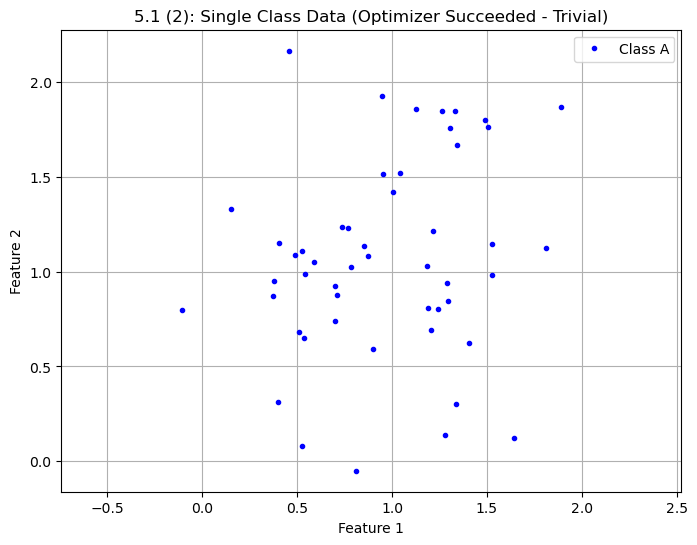

In [51]:
# --- Part 5.1 (2): Optimizer Failure Example ---

print("\n5.1(2) Optimizer Failure (Single Class Data)")

# Parameters
single_classA_params = {'n': 50, 'std': 0.5, 'center': [1, 1]}
C_value_fail = 1.0

# Data gen. of Only Class A:
np.random.seed(103)
classA_fail = np.random.randn(single_classA_params['n'], 2) * single_classA_params['std'] + single_classA_params['center']
inputs_fail = classA_fail
targets_fail = np.ones(classA_fail.shape[0])
n_train_fail = inputs_fail.shape[0]

# Svm run:
if n_train_fail > 0:
    P = __compute_P_mat(targets_fail, inputs_fail, kernel) # Set global P
    alpha_0_fail = np.zeros(n_train_fail)
    bounds_fail = [(0, C_value_fail) for _ in range(n_train_fail)]
    constraint_fail = {'type':'eq', 'fun':__zerofun, 'args':(targets_fail,)}
    print("Calling minimize for single-class data...")
    min_fail = minimize(__objective, alpha_0_fail, bounds=bounds_fail, constraints=constraint_fail)
    print(f"Minimize finished. Success: {min_fail.success}")

    # 3. Report Outcome & Plot Data Only
    plt.figure(figsize=(8, 6))
    plt.plot([p[0] for p in classA_fail], [p[1] for p in classA_fail], 'b.', label='Class A')
    title_fail = "5.1 (2): Single Class Data "
    if min_fail.success:
        title_fail += "(Optimizer Succeeded - Trivial)"
        print("Optimizer reported SUCCESS (likely trivial alpha=0 solution).")
    else:
        title_fail += "(Optimizer Failed)"
        print(f"ERROR: Optimization FAILED. Message: {min_fail.message}")

    plt.title(title_fail)
    plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
    plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

else:
    print("Skipping single-class test as n_train is 0.")

## 5.2 Testing non-linear kernels
Once you have the linear kernel up and running, you can explore a dataset that is not linearly separable.

(1) Try to use a polynomial kernel to classify the dataset below.

(2) Try to use an rbf kernel to classify the dataset below. Below is an example of how the RBF kernel could look.

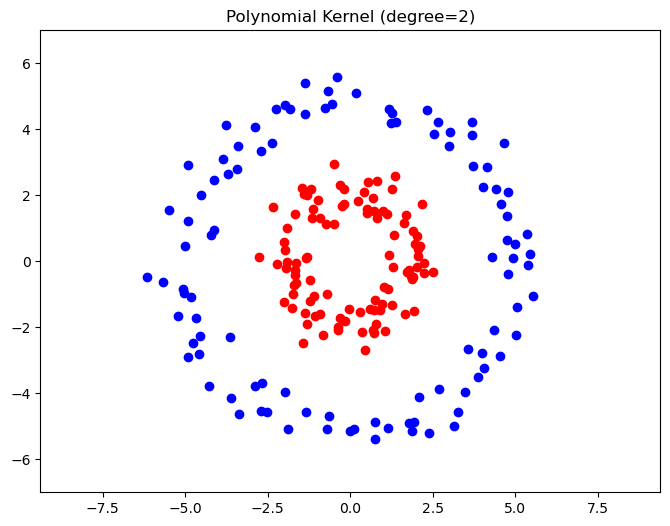

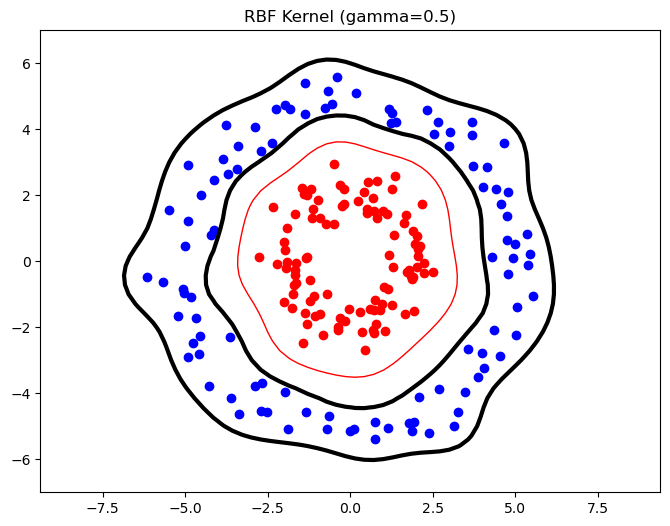

In [81]:
import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# gen. Concentric circles:
np.random.seed(100)
n_samples = 200
theta = np.linspace(0, 2*np.pi, n_samples//2)

# Outer circle (class A)
radius_outer = 5
classA = np.column_stack([radius_outer*np.cos(theta), 
                        radius_outer*np.sin(theta)]) + np.random.randn(n_samples//2, 2)*0.4

# Inner circle (class B)
radius_inner = 2
classB = np.column_stack([radius_inner*np.cos(theta), 
                        radius_inner*np.sin(theta)]) + np.random.randn(n_samples//2, 2)*0.4

# A && B:
inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))
n_train = inputs.shape[0]
permute = list(range(n_train))
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

#------

# Define kernels
def linear_kernel(x, y):
    return np.dot(x, y)

def poly_kernel(x, y, degree=2, r=1):
    return (np.dot(x, y) + r) ** degree

def rbf_kernel(x, y, gamma=0.5):
    return np.exp(-gamma * np.linalg.norm(x-y)**2)

# Params:
C = 10          # Slack parameter
epsilon = 1e-5  # Threshold for alpha values
kernel = None    # Will be set for each experiment

def compute_P(t, X, kernel):
    """Compute P matrix for optimization"""
    n = len(X)
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            P[i][j] = t[i] * t[j] * kernel(X[i], X[j])
    return P

def objective(alpha):
    # dual formulat. object function
    return 0.5 * np.dot(alpha, np.dot(P, alpha)) - np.sum(alpha)

def zerofun(alpha):
    # = constraint
    return np.dot(alpha, targets)

def compute_b(alpha, X, t):
    # getting bias term w/ supp. vectors
    sv = [(alpha[i], X[i], t[i]) for i in range(len(alpha)) if alpha[i] > epsilon]
    support_vectors = [v for v in sv if v[0] < C - epsilon]
    
    if not support_vectors:
        support_vectors = sv
    
    b_total = 0
    for a_i, x_i, t_i in support_vectors:
        total = 0
        for a_j, x_j, t_j in sv:
            total += a_j * t_j * kernel(x_j, x_i)
        b_total += t_i - total
    return b_total / len(support_vectors)

def indicator(x):
    # Classification decision function:
    total = 0
    for a_i, x_i, t_i in sv:
        total += a_i * t_i * kernel(x_i, x)
    return total - b

# Poly kernel of degree 2:
kernel = lambda x, y: poly_kernel(x, y, degree=2, r=1)

# P matrix & running:
P = compute_P(targets, inputs, kernel)
alpha_0 = np.zeros(n_train)
bounds = [(0, C) for _ in range(n_train)]
constraints = {'type': 'eq', 'fun': zerofun}

result = minimize(objective, alpha_0, bounds=bounds, constraints=constraints)
alpha = result.x

sv = [(alpha[i], inputs[i], targets[i]) for i in range(n_train) if alpha[i] > epsilon]

# bias:
b = compute_b(alpha, inputs, targets)

# plot:
plt.figure(figsize=(8, 6))
plt.scatter(classA[:, 0], classA[:, 1], c='b', label='Class A')
plt.scatter(classB[:, 0], classB[:, 1], c='r', label='Class B')

# grid -> decision boundaries:
xgrid = np.linspace(-7, 7, 50)
ygrid = np.linspace(-7, 7, 50)
grid = np.array([[indicator(np.array([x, y])) for x in xgrid] for y in ygrid])

plt.contour(xgrid, ygrid, grid, levels=[-1, 0, 1], 
           colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))
plt.title("Polynomial Kernel (degree=2)")
plt.axis('equal')
plt.show()

# RBF kernel, gamma 0.5:
kernel = lambda x, y: rbf_kernel(x, y, gamma=0.5)

# p matrix:
P = compute_P(targets, inputs, kernel)
result = minimize(objective, alpha_0, bounds=bounds, constraints=constraints)
alpha = result.x
sv = [(alpha[i], inputs[i], targets[i]) for i in range(n_train) if alpha[i] > epsilon]

# bias:
b = compute_b(alpha, inputs, targets)

plt.figure(figsize=(8, 6))
plt.scatter(classA[:, 0], classA[:, 1], c='b', label='Class A')
plt.scatter(classB[:, 0], classB[:, 1], c='r', label='Class B')

grid = np.array([[indicator(np.array([x, y])) for x in xgrid] for y in ygrid])

plt.contour(xgrid, ygrid, grid, levels=[-1, 0, 1], 
           colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))
plt.title("RBF Kernel (gamma=0.5)")
plt.axis('equal')
plt.show()

## 5.3 Kernel parameters

(1) Explore how the degree parameter of the polynomial kernel influences the decision boundary. Reason about this in terms of the bias variance trade-off. Explain using plots.

(2) Explore how the gamma parameter of the RBF kernel influences the decision boundary. Reason about this in terms of the bias variance trade-off. Explain using plots.


Polynomial Kernel Degree:


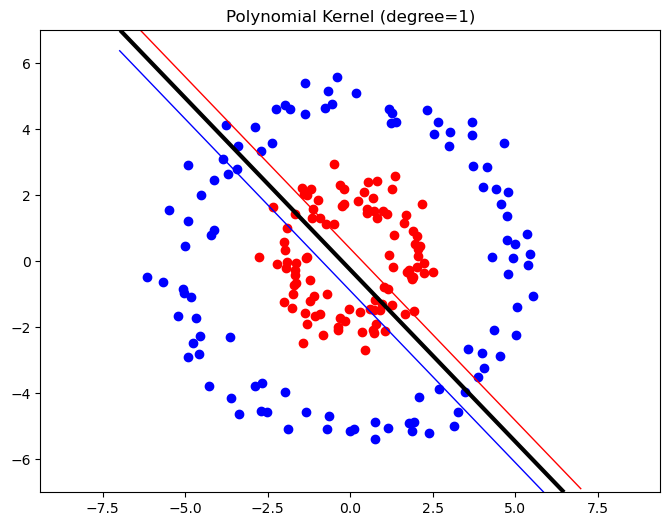

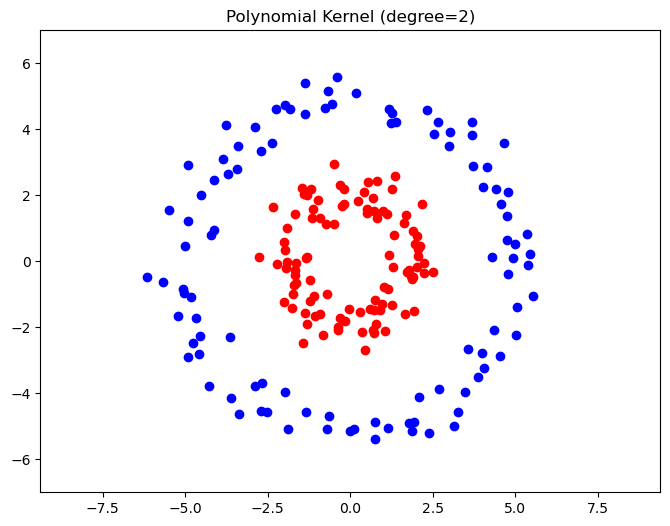

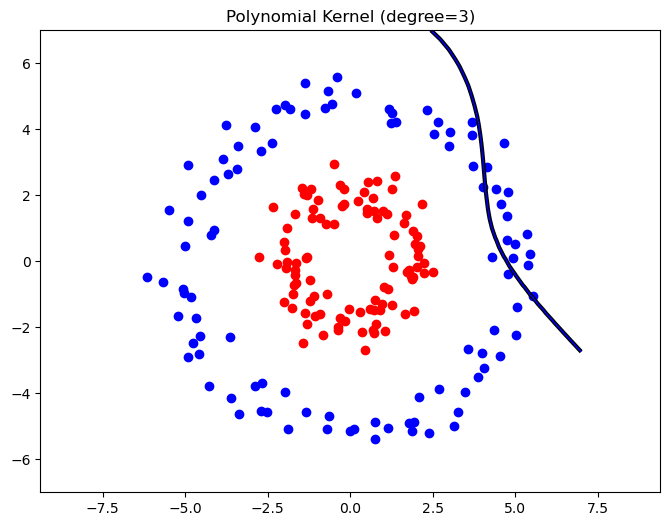

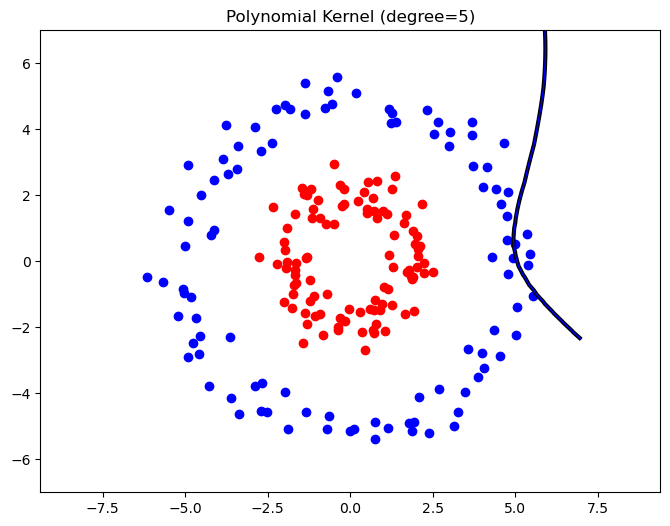


RBF Kernel Gamma:


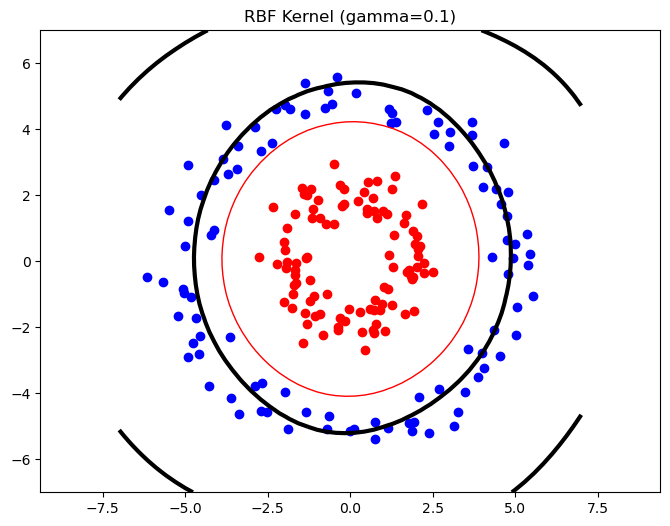

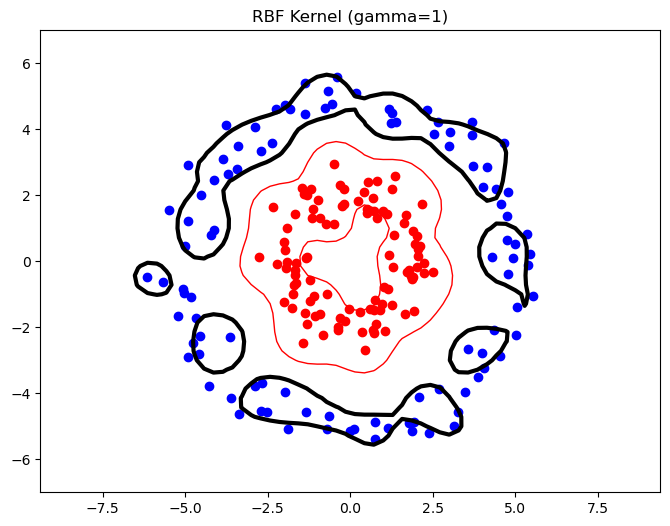

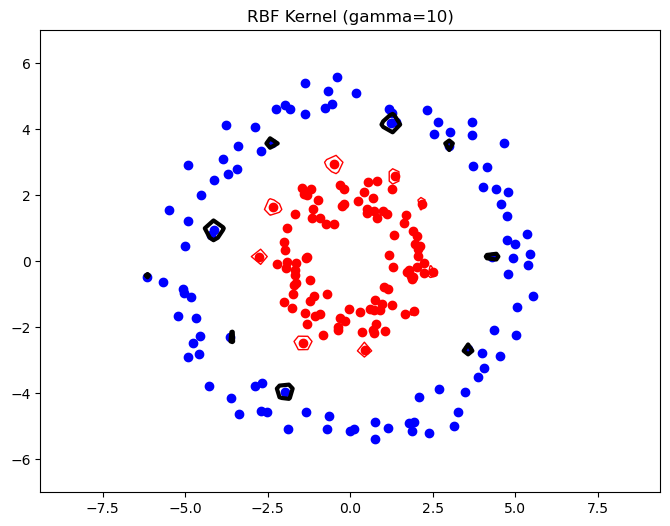

In [82]:
# gen. help functions:
def generate_concentric_circles():
    np.random.seed(100)
    n_samples = 200
    theta = np.linspace(0, 2*np.pi, n_samples//2)
    
    # Outer circle (class A)
    classA = np.column_stack([5*np.cos(theta), 5*np.sin(theta)]) + np.random.randn(n_samples//2, 2)*0.4
    
    # Inner circle (class B)
    classB = np.column_stack([2*np.cos(theta), 2*np.sin(theta)]) + np.random.randn(n_samples//2, 2)*0.4
    
    return classA, classB

def train_and_plot(kernel_func, C=10, title=''):
    classA, classB = generate_concentric_circles()
    inputs = np.concatenate((classA, classB))
    targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))
    n_train = inputs.shape[0]
    
    permute = list(range(n_train))
    random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]

    P = compute_P(targets, inputs, kernel_func)

    alpha_0 = np.zeros(n_train)
    bounds = [(0, C) for _ in range(n_train)]
    constraints = {'type': 'eq', 'fun': zerofun}
    result = minimize(objective, alpha_0, bounds=bounds, constraints=constraints)
    alpha = result.x

    
    sv = [(alpha[i], inputs[i], targets[i]) for i in range(n_train) if alpha[i] > 1e-5]
    
    b = compute_b(alpha, inputs, targets)

    plt.figure(figsize=(8, 6))
    plt.scatter(classA[:, 0], classA[:, 1], c='b', label='Class A')
    plt.scatter(classB[:, 0], classB[:, 1], c='r', label='Class B')

    xgrid = np.linspace(-7, 7, 50)
    ygrid = np.linspace(-7, 7, 50)
    grid = np.array([[indicator(np.array([x, y])) for x in xgrid] for y in ygrid])

    plt.contour(xgrid, ygrid, grid, levels=[-1, 0, 1], 
               colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Poly degree:
print("\nPolynomial Kernel Degree:")
degrees = [1, 2, 3, 5]

# degrees:
# 1 - linear, straight line boundary & high bias -> underfitting
# 2 - quadratic, better fit -> limited.
# 3 - complex boundary -> separation is working better.
# 4 - 
# 5 - more complex boundary -> overfitting (noise sensitive)

# tradeoffs:
# with low degrees, a high bias (underfits), low var.
# high degrees, low bias (overfits), high var.
# degree 2/3 shown as optimal.

for d in degrees:
    # Define polynomial kernel with current degree
    kernel = lambda x, y: (np.dot(x, y) + 1) ** d
    train_and_plot(kernel, title=f'Polynomial Kernel (degree={d})')

# RBF Gamma:
print("\nRBF Kernel Gamma:")
gammas = [0.1, 1, 10]

# gammas:
# 0.1 - smooth boundaries, high bias -> underfits
# 1 - balanced, good generalization of data
# 10 - complex boundary with overfitting, capturing noise

# better one: gamma 1

for g in gammas:
    # Define RBF kernel with current gamma
    kernel = lambda x, y: np.exp(-g * np.linalg.norm(x-y)**2)
    train_and_plot(kernel, title=f'RBF Kernel (gamma={g})')

# Core SVM:
def compute_P(t, X, kernel):
    n = len(X)
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            P[i][j] = t[i] * t[j] * kernel(X[i], X[j])
    return P

def objective(alpha):
    return 0.5 * np.dot(alpha, np.dot(P, alpha)) - np.sum(alpha)

def zerofun(alpha):
    return np.dot(alpha, targets)

def compute_b(alpha, X, t):
    sv = [(alpha[i], X[i], t[i]) for i in range(len(alpha)) if alpha[i] > 1e-5]
    support_vectors = [v for v in sv if v[0] < 10 - 1e-5]
    
    if not support_vectors:
        support_vectors = sv
    
    b_total = 0
    for a_i, x_i, t_i in support_vectors:
        total = 0
        for a_j, x_j, t_j in sv:
            total += a_j * t_j * kernel(x_j, x_i)
        b_total += t_i - total
    return b_total / len(support_vectors)

def indicator(x):
    total = 0
    for a_i, x_i, t_i in sv:
        total += a_i * t_i * kernel(x_i, x)
    return total - b

## 5.4 Slack parameter
Explore the role of the slack parameter C for the various kernels. What happens for very large/small values? Illustrate your answer with plots.

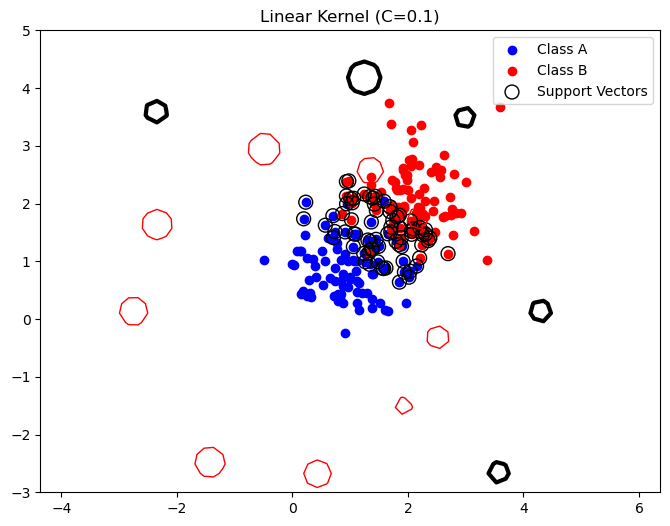

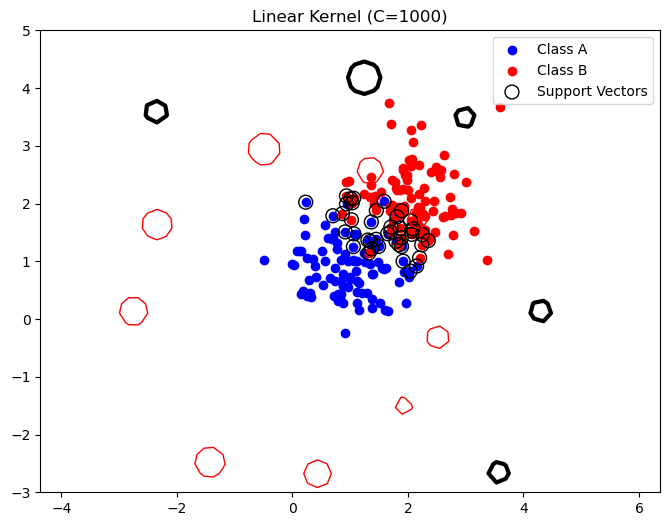

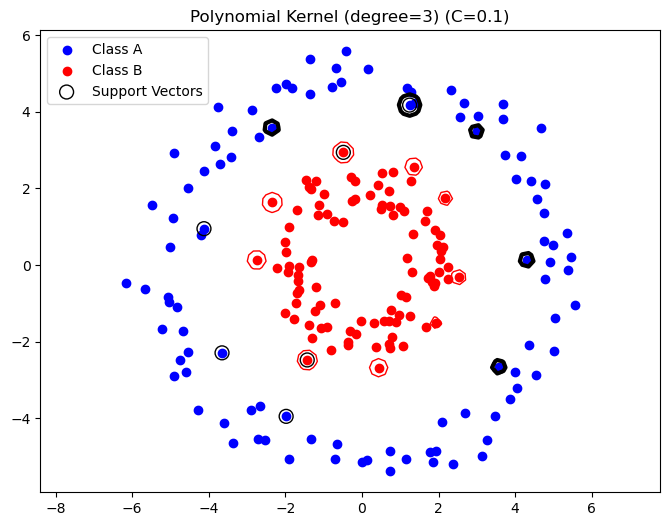

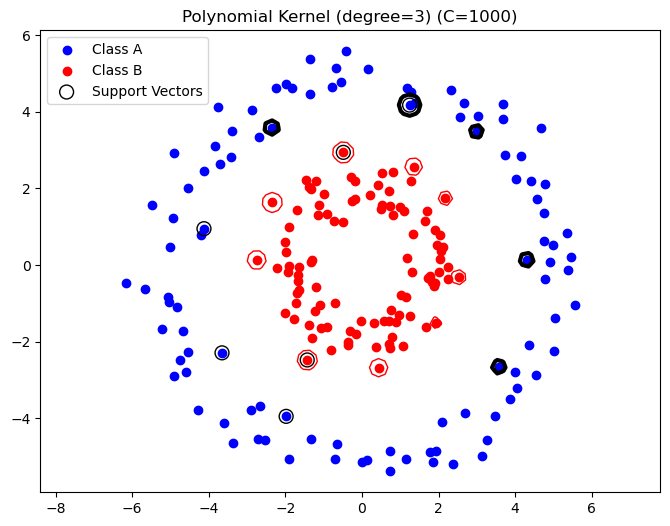

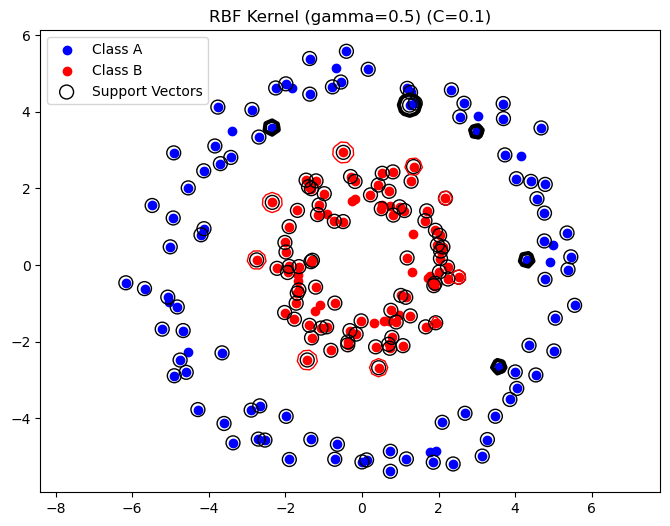

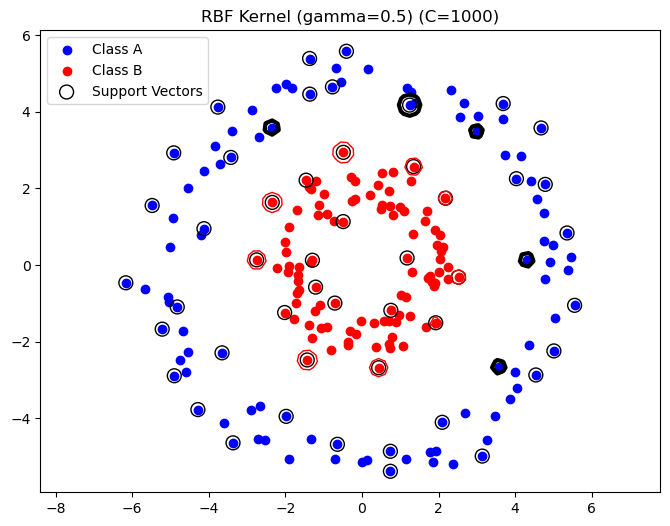

In [83]:
import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# data generalization:
def generate_overlapping_linear_data():
    np.random.seed(100)
    classA = np.random.randn(100, 2) * 0.5 + [1, 1]  # overlapping classes
    classB = np.random.randn(100, 2) * 0.5 + [2, 2]
    return classA, classB

def generate_nonlinear_data():
    np.random.seed(100)
    theta = np.linspace(0, 2*np.pi, 100)
    classA = np.column_stack([5*np.cos(theta), 5*np.sin(theta)]) + np.random.randn(100, 2)*0.4
    classB = np.column_stack([2*np.cos(theta), 2*np.sin(theta)]) + np.random.randn(100, 2)*0.4
    return classA, classB

# svm training:
def train_and_plot(kernel_func, C, data_generator, title):
    classA, classB = data_generator()
    inputs = np.concatenate((classA, classB))
    targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))
    n_train = inputs.shape[0]
    
    permute = list(range(n_train))
    random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]

    def compute_P(t, X):
        n = len(X)
        P = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                P[i][j] = t[i] * t[j] * kernel_func(X[i], X[j])
        return P
    P = compute_P(targets, inputs)

    alpha_0 = np.zeros(n_train)
    bounds = [(0, C) for _ in range(n_train)]
    constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, targets)}
    result = minimize(lambda alpha: 0.5 * np.dot(alpha, np.dot(P, alpha)) - np.sum(alpha),
                      alpha_0, bounds=bounds, constraints=constraints)
    alpha = result.x

    sv = [(alpha[i], inputs[i], targets[i]) for i in range(n_train) if alpha[i] > 1e-5]
    b = compute_b(alpha, inputs, targets)  # Use compute_b from previous code

    plt.figure(figsize=(8, 6))
    plt.scatter(classA[:, 0], classA[:, 1], c='b', label='Class A')
    plt.scatter(classB[:, 0], classB[:, 1], c='r', label='Class B')
    plt.scatter([x[1][0] for x in sv], [x[1][1] for x in sv], 
                facecolors='none', edgecolors='k', s=100, label='Support Vectors')

    # decision boundary:
    xgrid = np.linspace(-3, 5, 50)
    ygrid = np.linspace(-3, 5, 50)
    grid = np.array([[indicator(np.array([x, y])) for x in xgrid] for y in ygrid])
    plt.contour(xgrid, ygrid, grid, levels=[-1, 0, 1], 
                colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))
    plt.title(f"{title} (C={C})")
    plt.axis('equal')
    plt.legend()
    plt.show()

# Experimenting diff. C values

# Linear -> overlapping data
for C in [0.1, 1000]:
    train_and_plot(
        kernel_func=lambda x, y: np.dot(x, y),
        C=C,
        data_generator=generate_overlapping_linear_data,
        title="Linear Kernel"
    )

# Polynomial -> non-linear data
for C in [0.1, 1000]:
    train_and_plot(
        kernel_func=lambda x, y: (np.dot(x, y) + 1)**3,
        C=C,
        data_generator=generate_nonlinear_data,
        title="Polynomial Kernel (degree=3)"
    )

# RBF Kernel -0 non-linear data:
for C in [0.1, 1000]:
    train_and_plot(
        kernel_func=lambda x, y: np.exp(-0.5 * np.linalg.norm(x-y)**2),
        C=C,
        data_generator=generate_nonlinear_data,
        title="RBF Kernel (gamma=0.5)"
    )

## 5.5 Sklearn SVM
Sklearn have a package for implementing SVMs. Apply this model to the generated data - how does the RBF kernel compare with the ones you have created? Explain using plots. Hint: You can make use of the model.decision function to plot the decision boundary.

Using non-linear data from Section 5.2 for sklearn comparison.

--- Fitting sklearn SVC (RBF kernel, C=1.0, gamma=1.0) ---
Sklearn found 31 support vectors.
Sklearn support vector indices: [ 34  88  90 101 102 110 114 120 136 140 149 160 166 173  23  35  40  45
  71  74  77  80 124 130 148 162 170 172 181 185 188]


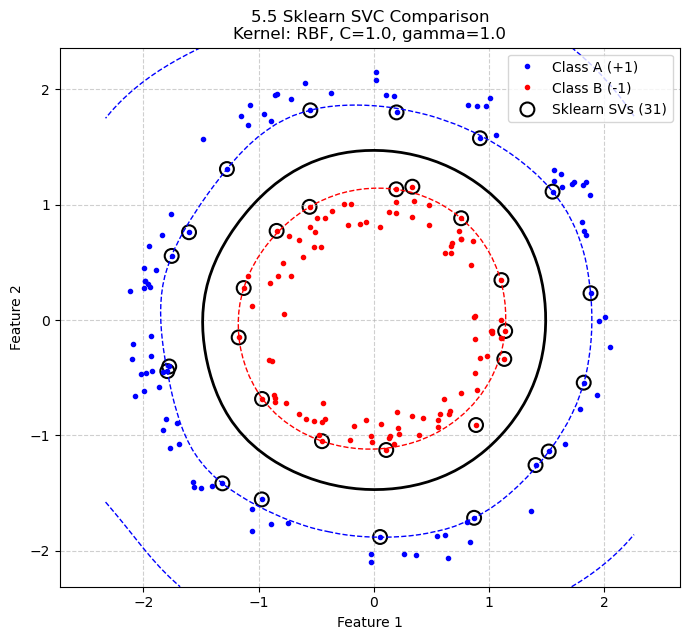

NameError: name 'time' is not defined

In [79]:
from sklearn import svm

SVC = svm.SVC(kernel = 'rbf', C=1, gamma = 1)
SVC.fit(inputs, targets)

try:
    _ = classA_nl
    _ = classB_nl
    print("Using non-linear data from section 5.2 for sklearn comparison.")
except NameError:
    print("nameerror")
    classA_nl, classB_nl = generate_nonlinear_data(n_samples=200, noise=0.1)

C_sklearn = 1.0
gamma_sklearn = 1.0 # matching the gamma I used for RBF experiment for 5.2

print(f"\nsklearn SVC (RBF kernel, C={C_sklearn}, gamma={gamma_sklearn}) ---")
inputs_sklearn = np.concatenate((classA_nl, classB_nl))
targets_sklearn = np.concatenate((np.ones(classA_nl.shape[0]), -np.ones(classB_nl.shape[0])))
permute_sklearn = list(range(inputs_sklearn.shape[0]))
random.shuffle(permute_sklearn)
inputs_sklearn = inputs_sklearn[permute_sklearn, :]
targets_sklearn = targets_sklearn[permute_sklearn]

# sklearn SVC
svc_model = svm.SVC(kernel='rbf', C=C_sklearn, gamma=gamma_sklearn)
svc_model.fit(inputs_sklearn, targets_sklearn)

print(f"Sklearn w/ {len(svc_model.support_)} support vectors.")
print(f"Sklearn sv indices: {svc_model.support_}")

plt.figure(figsize=(8, 7))
plt.plot([p[0] for p in classA_nl], [p[1] for p in classA_nl], 'b.', label='Class A (+1)')
plt.plot([p[0] for p in classB_nl], [p[1] for p in classB_nl], 'r.', label='Class B (-1)')
plt.scatter(svc_model.support_vectors_[:, 0], svc_model.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='k', linewidth=1.5, label=f'Sklearn SVs ({len(svc_model.support_)})')

# grid, decision_function:
x_min_sk, x_max_sk = plt.xlim()
y_min_sk, y_max_sk = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min_sk, x_max_sk, 60),
                     np.linspace(y_min_sk, y_max_sk, 60))
Z = svc_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'],
            linewidths=(1, 2, 1), colors=('red', 'black', 'blue'))

plt.title(f"5.5 Sklearn SVC Comparison\nKernel: RBF, C={C_sklearn}, gamma={gamma_sklearn}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
time.sleep(0.5)

# The one that most compare is the last section's RBF of degree 3 and c 0.1, since
# both have similar trends at (-2,0.5) and (1,1.5), overfitting class b and
# underfitting class a.